170500096/170498071 [==============================] - 6s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32) 

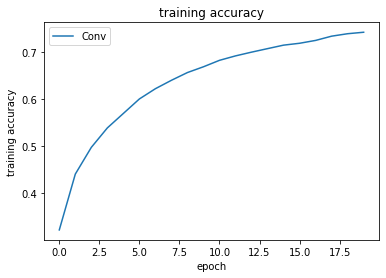

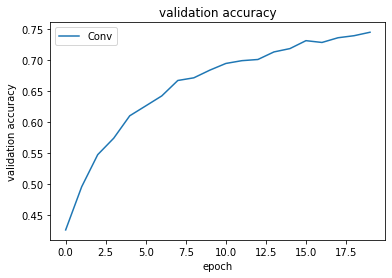

313/313 [==============================] - 1s 4ms/step - loss: 0.7656 - accuracy: 0.7358
Test accuracy: 0.73580002784729


In [2]:
# libraries (do not import additional libraries)
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import math
import matplotlib.pyplot as plt

# parameters for this script
batch_size = 32
num_classes = 10
epochs = 20          # 20
data_augmentation = False

# Load the data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Define a convolutional neural network
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# Compile the model before using it
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
print(model.summary())

# normalize the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# partition training set into training and validation set
x_validate = x_train[40000:,:]
x_train = x_train[:40000,:]
y_validate = y_train[40000:,:]
y_train = y_train[:40000,:]

# create a callback that will save the best model while training
save_best_model = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# train without data augmentation
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        callbacks=[save_best_model])

# train with data augmentation
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=math.ceil(x_train.shape[0]/batch_size),
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        callbacks=[save_best_model])
    
# Plot training accuracy
plt.plot(history.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()

# Plot validation accuracy
plt.plot(history.history['val_accuracy'])
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
saved_model = load_model('best_model.h5')

scores = saved_model.evaluate(x_test, y_test, verbose=1)
print('Test accuracy:', scores[1])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                30730     
_________________________________________________________________
activation_18 (Activation)   (None, 10)                0         
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_7 (Dense) 

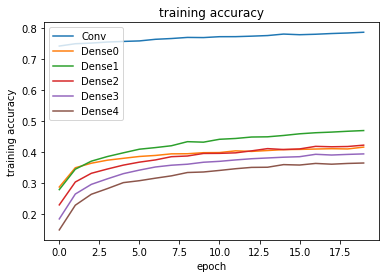

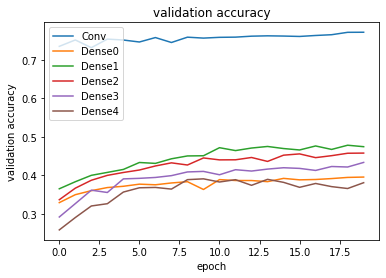

313/313 [==============================] - 1s 3ms/step - loss: 1.7487 - accuracy: 0.4006
Test accuracy conv: 0.7638999819755554
Test accuracy dense0: 0.39430001378059387
Test accuracy dense1: 0.4846999943256378
Test accuracy dense2: 0.4602999985218048
Test accuracy dense3: 0.44040000438690186
Test accuracy dense4: 0.40059998631477356


In [4]:
#Part1 - simple dense neural networks with 0, 1, 2, 3 and 4 hidden layers of 512 rectified linear units each
# parameters for this script
batch_size = 32
num_classes = 10
epochs = 20          # 20
data_augmentation = False

# Load the data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model_0 = keras.Sequential(
    [
     keras.layers.Flatten(input_shape = x_train.shape[1:]),
     keras.layers.Dense(num_classes),
     keras.layers.Activation('softmax'),                                  
    ]
)

model_1 = keras.Sequential(
    [
     keras.layers.Flatten(input_shape = x_train.shape[1:]),
     keras.layers.Dense(512, activation = 'relu'),
     keras.layers.Dropout(0.5),
     keras.layers.Dense(num_classes),
     keras.layers.Activation('softmax'),    
    ]
)

model_2 = keras.Sequential(
    [
     keras.layers.Flatten(input_shape = x_train.shape[1:]),
     keras.layers.Dense(512, activation = 'relu'),
     keras.layers.Dropout(0.5),
     keras.layers.Dense(512, activation = 'relu'),
     keras.layers.Dropout(0.5),
     keras.layers.Dense(num_classes),
     keras.layers.Activation('softmax'),    
    ]
)

model_3 = keras.Sequential(
    [
     keras.layers.Flatten(input_shape = x_train.shape[1:]),
     keras.layers.Dense(512, activation = 'relu'),
     keras.layers.Dropout(0.5),
     keras.layers.Dense(512, activation = 'relu'),
     keras.layers.Dropout(0.5),
     keras.layers.Dense(512, activation = 'relu'),
     keras.layers.Dropout(0.5),
     keras.layers.Dense(num_classes),
     keras.layers.Activation('softmax'),    
    ]
)

model_4 = keras.Sequential(
    [
     keras.layers.Flatten(input_shape = x_train.shape[1:]),
     keras.layers.Dense(512, activation = 'relu'),
     keras.layers.Dropout(0.5),
     keras.layers.Dense(512, activation = 'relu'),
     keras.layers.Dropout(0.5),
     keras.layers.Dense(512, activation = 'relu'),
     keras.layers.Dropout(0.5),
     keras.layers.Dense(512, activation = 'relu'),
     keras.layers.Dropout(0.5),
     keras.layers.Dense(num_classes),
     keras.layers.Activation('softmax'),    
    ]
)


# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
# Compile the model before using it
model_0.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model_1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model_2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model_3.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model_4.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(model_0.summary())
print(model_1.summary())
print(model_2.summary())
print(model_3.summary())
print(model_4.summary())

# normalize the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# partition training set into training and validation set
x_validate = x_train[40000:,:]
x_train = x_train[:40000,:]
y_validate = y_train[40000:,:]
y_train = y_train[:40000,:]

# create a callback that will save the best model while training
saved_best_model = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
saved_best_model_0 = ModelCheckpoint('dense_model_0.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
saved_best_model_1 = ModelCheckpoint('dense_model_1.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
saved_best_model_2 = ModelCheckpoint('dense_model_2.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
saved_best_model_3 = ModelCheckpoint('dense_model_3.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
saved_best_model_4 = ModelCheckpoint('dense_model_4.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# train without data augmentation
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        callbacks=[saved_best_model])
    history_0 = model_0.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        callbacks=[saved_best_model_0])
    history_1 = model_1.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        callbacks=[saved_best_model_1])
    history_2 = model_2.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        callbacks=[saved_best_model_2])
    history_3 = model_3.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        callbacks=[saved_best_model_3])
    history_4 = model_4.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        callbacks=[saved_best_model_4])
                    
# train with data augmentation
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the conv_model on the batches generated by datagen.flow().
    history = conv_model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=math.ceil(x_train.shape[0]/batch_size),
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        callbacks=[save_best_conv_model])

# Plot training accuracy
plt.plot(history.history['accuracy'])
plt.plot(history_0.history['accuracy'])
plt.plot(history_1.history['accuracy'])
plt.plot(history_2.history['accuracy'])
plt.plot(history_3.history['accuracy'])
plt.plot(history_4.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['Conv', 'Dense0', 'Dense1', 'Dense2', 'Dense3', 'Dense4'], loc='upper left')
plt.show()

# Plot validation accuracy
plt.plot(history.history['val_accuracy'])
plt.plot(history_0.history['val_accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['Conv', 'Dense0', 'Dense1', 'Dense2', 'Dense3', 'Dense4'], loc='upper left')
plt.show()

# Evaluate the best conv_model saved (i.e., conv_model with best validation accuracy) on the test set
saved_conv_model = load_model('best_model.h5')
save_best_dense0_model = load_model('dense_model_0.h5')
save_best_dense1_model = load_model('dense_model_1.h5')
save_best_dense2_model = load_model('dense_model_2.h5')
save_best_dense3_model = load_model('dense_model_3.h5')
save_best_dense4_model = load_model('dense_model_4.h5')
test_scores_conv = saved_conv_model.evaluate(x_test, y_test, verbose=1)
test_scores_dense0 = save_best_dense0_model.evaluate(x_test, y_test, verbose=1)
test_scores_dense1 = save_best_dense1_model.evaluate(x_test, y_test, verbose=1)
test_scores_dense2 = save_best_dense2_model.evaluate(x_test, y_test, verbose=1)
test_scores_dense3 = save_best_dense3_model.evaluate(x_test, y_test, verbose=1)
test_scores_dense4 = save_best_dense4_model.evaluate(x_test, y_test, verbose=1)
print('Test accuracy conv:', test_scores_conv[1])
print('Test accuracy dense0:', test_scores_dense0[1])
print('Test accuracy dense1:', test_scores_dense1[1])
print('Test accuracy dense2:', test_scores_dense2[1])
print('Test accuracy dense3:', test_scores_dense3[1])
print('Test accuracy dense4:', test_scores_dense4[1])


As we can see from the figure above, the performance from convolutional network is way better than other dense nueral network with 0, 1, 2 ,3 and 4 dense layer. This is because the convolution network is sparse with shared weights, which helps to obtain a good result with simplified optimization. However, as we can see from the figure about the dense neural network, with the increases in the dense hidden layers, the optimization becomes more complex and it makes harder to obtain the best weights. From above, we can observe that the performance of network with 1 dense layer and 2 dense layer are better than others in validation, which means it probably achieve the optimial weights with 1 or 2 dense layer. With more dense layers, it might just has the problem of overfitting.


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 32)        0         
_______________________________________________

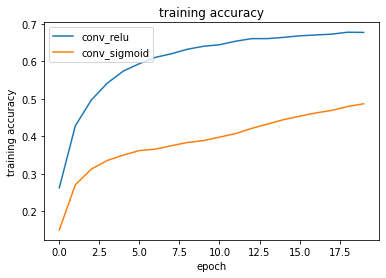

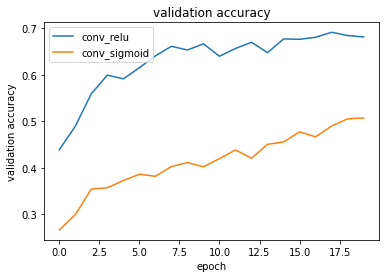

313/313 [==============================] - 1s 3ms/step - loss: 1.3437 - accuracy: 0.5099
Test accuracy relu: 0.6862000226974487
Test accuracy sigmoid: 0.5098999738693237


In [2]:
# Part 2
#Compare the accuracy achieved by rectified linear units and sigmoid units in the convolutional neural network
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import math
import matplotlib.pyplot as plt

batch_size = 32
num_classes = 10
epochs = 20          # 20
data_augmentation = False

# Load the data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


# Define a convolutional neural network
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# using sigmoid as activation function
model_sig = Sequential()
model_sig.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model_sig.add(Activation('sigmoid'))
model_sig.add(Conv2D(32, (3, 3), padding='same'))
model_sig.add(Activation('sigmoid'))
model_sig.add(MaxPooling2D(pool_size=(2, 2)))
model_sig.add(Dropout(0.25))

model_sig.add(Conv2D(64, (3, 3), padding='same'))
model_sig.add(Activation('sigmoid'))
model_sig.add(Conv2D(64, (3, 3), padding='same'))
model_sig.add(Activation('sigmoid'))
model_sig.add(MaxPooling2D(pool_size=(2, 2)))
model_sig.add(Dropout(0.25))

model_sig.add(Flatten())
model_sig.add(Dense(512))
model_sig.add(Activation('sigmoid'))
model_sig.add(Dropout(0.5))
model_sig.add(Dense(num_classes))
model_sig.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# Compile the conv_model and dense models before using it
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model_sig.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


print(model.summary())
print(model_sig.summary())


# partition training set into training and validation set
x_validate = x_train[40000:,:]
x_train = x_train[:40000,:]
y_validate = y_train[40000:,:]
y_train = y_train[:40000,:]

# create a callback that will save the best models while training
save_best_relu_model = ModelCheckpoint('model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
save_best_sig_model = ModelCheckpoint('model_sig.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)


# train without data augmentation
if not data_augmentation:
    print('Not using data augmentation.')
    history_relu = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        verbose=1,
                        callbacks=[save_best_relu_model])
    
    history_sig = model_sig.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        verbose=1,
                        callbacks=[save_best_sig_model])
    

# Plot training accuracy
plt.plot(history_relu.history['accuracy'])
plt.plot(history_sig.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['conv_relu', 'conv_sigmoid'], loc='upper left')
plt.show()

# Plot validation accuracy
plt.plot(history_relu.history['val_accuracy'])
plt.plot(history_sig.history['val_accuracy'])
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['conv_relu', 'conv_sigmoid'], loc='upper left')
plt.show()

# Evaluate the best conv_model saved (i.e., conv_model with best validation accuracy) on the test set
saved_model_relu = load_model('model.h5')
saved_model_sig = load_model('model_sig.h5')
test_scores_relu = saved_model_relu.evaluate(x_test, y_test, verbose=1)
test_scores_sig = saved_model_sig.evaluate(x_test, y_test, verbose=1)
print('Test accuracy relu:', test_scores_relu[1])
print('Test accuracy sigmoid:', test_scores_sig[1])

From above figures, relu has a better performance than sigmoid as activiation function no matter validation or testing accuracy. From Lecture 15, Sigmoid has a disadvantage of dealing with the gradient vanishing. The improvement of the model with sigmoid as activation function is relatively slow compared to the model with relu activation function. I guess this might due to the problem of gradient vanishing.

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_89 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_90 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 16, 16, 64)        18496     
______________________________________________

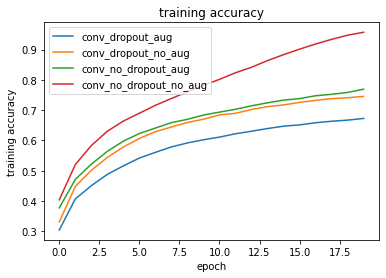

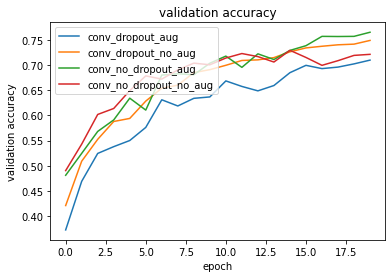

313/313 [==============================] - 2s 5ms/step - loss: 0.9256 - accuracy: 0.7265
Test accuracy dropout with data augmentation: 0.7045999765396118
Test accuracy dropout with no data augmentation:: 0.7376999855041504
Test accuracy no dropout with data augmentation: 0.753000020980835
Test accuracy no dropout with no data augmentation:: 0.7264999747276306


In [10]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import math
import matplotlib.pyplot as plt

# parameters for this script
batch_size = 32
num_classes = 10
epochs = 20          # 20
data_augmentation = False

# Load the data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# define a convolution neural netwrok with dropout
model_dropout = Sequential()
model_dropout.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model_dropout.add(Activation('relu'))
model_dropout.add(Conv2D(32, (3, 3), padding='same'))
model_dropout.add(Activation('relu'))
model_dropout.add(MaxPooling2D(pool_size=(2, 2)))
model_dropout.add(Dropout(0.25))

model_dropout.add(Conv2D(64, (3, 3), padding='same'))
model_dropout.add(Activation('relu'))
model_dropout.add(Conv2D(64, (3, 3), padding='same'))
model_dropout.add(Activation('relu'))
model_dropout.add(MaxPooling2D(pool_size=(2, 2)))
model_dropout.add(Dropout(0.25))

model_dropout.add(Flatten())
model_dropout.add(Dense(512))
model_dropout.add(Activation('relu'))
model_dropout.add(Dropout(0.5))
model_dropout.add(Dense(num_classes))
model_dropout.add(Activation('softmax'))

# define a convolution neural network without dropout rate from sample code
model_no_dropout = Sequential()
model_no_dropout.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model_no_dropout.add(Activation('relu'))
model_no_dropout.add(Conv2D(32, (3, 3), padding='same'))
model_no_dropout.add(Activation('relu'))
model_no_dropout.add(MaxPooling2D(pool_size=(2, 2)))

model_no_dropout.add(Conv2D(64, (3, 3), padding='same'))
model_no_dropout.add(Activation('relu'))
model_no_dropout.add(Conv2D(64, (3, 3), padding='same'))
model_no_dropout.add(Activation('relu'))
model_no_dropout.add(MaxPooling2D(pool_size=(2, 2)))

model_no_dropout.add(Flatten())
model_no_dropout.add(Dense(512))
model_no_dropout.add(Activation('relu'))
model_no_dropout.add(Dense(num_classes))
model_no_dropout.add(Activation('softmax'))

# clone model used for different data set with or without augmentation
model_dropout_aug = keras.models.clone_model(model_dropout)
model_dropout_no_aug = keras.models.clone_model(model_dropout)
model_no_dropout_aug = keras.models.clone_model(model_no_dropout)
model_no_dropout_no_aug = keras.models.clone_model(model_no_dropout)

# initiate RMSprop optimizer
opt1 = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
opt2 = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
opt3 = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
opt4= keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# Compile the model before using it
model_dropout_aug.compile(loss='categorical_crossentropy',
              optimizer=opt1,
              metrics=['accuracy'])
model_dropout_no_aug.compile(loss='categorical_crossentropy',
              optimizer=opt2,
              metrics=['accuracy'])
model_no_dropout_aug.compile(loss='categorical_crossentropy',
              optimizer=opt3,
              metrics=['accuracy'])
model_no_dropout_no_aug.compile(loss='categorical_crossentropy',
              optimizer=opt4,
              metrics=['accuracy'])

print(model_no_dropout_aug.summary())
print(model_no_dropout_no_aug.summary())
print(model_dropout_aug.summary())
print(model_dropout_no_aug.summary())

# normalize the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# partition training set into training and validation set
x_validate = x_train[40000:,:]
x_train = x_train[:40000,:]
y_validate = y_train[40000:,:]
y_train = y_train[:40000,:]

# create a callback that will save the best models while training with/without data augmentation
save_best_conv_model_dropout_aug = ModelCheckpoint('best_model_dropout_aug.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
save_best_model_dropout_no_aug = ModelCheckpoint('best_model_dropout_no_aug.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
save_best_conv_model_no_dropout_aug = ModelCheckpoint('best_model_no_dropout_aug.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
save_best_model_no_dropout_no_aug = ModelCheckpoint('best_model_no_dropout_no_aug.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# train without data augmentation
print('Not using data augmentation.')
history_model_dropout_no_aug = model_dropout_no_aug.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_validate, y_validate),
                    shuffle=True,
                    verbose=1,
                    callbacks=[save_best_model_dropout_no_aug])

history_model_no_dropout_no_aug = model_no_dropout_no_aug.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_validate, y_validate),
                    shuffle=True,
                    verbose=1,
                    callbacks=[save_best_model_no_dropout_no_aug])

# train with data augmentation

print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zca_epsilon=1e-06,  # epsilon for ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    shear_range=0.,  # set range for random shear
    zoom_range=0.,  # set range for random zoom
    channel_shift_range=0.,  # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0.,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the conv_model on the batches generated by datagen.flow().

history_model_no_dropout_aug = model_no_dropout_aug.fit(
                    datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=math.ceil(x_train.shape[0]/batch_size),
                    epochs=epochs,
                    validation_data=(x_validate, y_validate),
                    # shuffle=True,
                    verbose=1,
                    callbacks=[save_best_conv_model_no_dropout_aug])

history_model_dropout_aug = model_dropout_aug.fit(
                    datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=math.ceil(x_train.shape[0]/batch_size),
                    epochs=epochs,
                    validation_data=(x_validate, y_validate),
                    # shuffle=True,
                    verbose=1,
                    callbacks=[save_best_conv_model_dropout_aug])

# Plot training accuracy
plt.plot(history_model_dropout_aug.history['accuracy'])
plt.plot(history_model_dropout_no_aug.history['accuracy'])
plt.plot(history_model_no_dropout_aug.history['accuracy'])
plt.plot(history_model_no_dropout_no_aug.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['conv_dropout_aug', 'conv_dropout_no_aug', 'conv_no_dropout_aug', 'conv_no_dropout_no_aug'], loc='upper left')
plt.show()

# Plot validation accuracy
plt.plot(history_model_dropout_aug.history['val_accuracy'])
plt.plot(history_model_dropout_no_aug.history['val_accuracy'])
plt.plot(history_model_no_dropout_aug.history['val_accuracy'])
plt.plot(history_model_no_dropout_no_aug.history['val_accuracy'])
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['conv_dropout_aug', 'conv_dropout_no_aug', 'conv_no_dropout_aug', 'conv_no_dropout_no_aug'], loc='upper left')
plt.show()

# Evaluate the best conv_model saved (i.e., conv_model with best validation accuracy) on the test set
saved_model_dropout_aug = load_model('best_model_dropout_aug.h5')
saved_model_dropout_no_aug = load_model('best_model_dropout_no_aug.h5')
saved_model_no_dropout_aug = load_model('best_model_no_dropout_aug.h5')
saved_model_no_dropout_no_aug = load_model('best_model_no_dropout_no_aug.h5')
test_scores_dropout_aug = saved_model_dropout_aug.evaluate(x_test, y_test, verbose=1)
test_scores_dropout_no_aug = saved_model_dropout_no_aug.evaluate(x_test, y_test, verbose=1)
test_scores_no_dropout_aug = saved_model_no_dropout_aug.evaluate(x_test, y_test, verbose=1)
test_scores_no_dropout_no_aug = saved_model_no_dropout_no_aug.evaluate(x_test, y_test, verbose=1)
print('Test accuracy dropout with data augmentation:', test_scores_dropout_aug[1])
print('Test accuracy dropout with no data augmentation::', test_scores_dropout_no_aug[1])
print('Test accuracy no dropout with data augmentation:', test_scores_no_dropout_aug[1])
print('Test accuracy no dropout with no data augmentation::', test_scores_no_dropout_no_aug[1])

The model without dropout or data augmentation has the highest accuracy in testing because there is less data in training set, which is reasonable that it has a higher accuracy. However, it is also proved that the model has been overfitted the most since its validation accuracy ranks 3 among 4. From the lecture, Dropout prevents overfitting, and data agmentation generates more data ,which helps on generalization. Therefore, obviously, model without dropout and no data agmentation has an overfitting problem.

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_101 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_102 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 16, 16, 32)        0         
______________________________________________

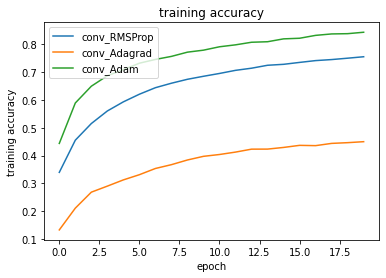

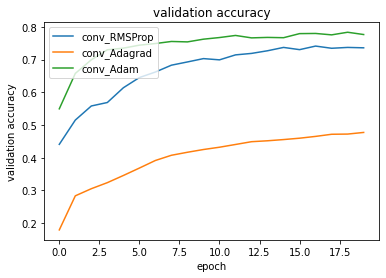

313/313 [==============================] - 2s 5ms/step - loss: 0.7017 - accuracy: 0.7744
Test accuracy RMSprop: 0.7372000217437744
Test accuracy Adagrad: 0.4837999939918518
Test accuracy Adam: 0.774399995803833


In [12]:
# Part 4 - try three different optimizer

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import math
import matplotlib.pyplot as plt

# parameters for this script
batch_size = 32
num_classes = 10
epochs = 20          # 20
data_augmentation = False

# Load the data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# define a convolution neural netwrok with dropout
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# clone model used for 3 different optimizer
model_RMSprop = keras.models.clone_model(model)
model_Adagrad = keras.models.clone_model(model)
model_Adam = keras.models.clone_model(model)

# initiate RMSprop optimizer
opt_RMSprop = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
# initiate Adagrad optimizer
opt_Adagrad = keras.optimizers.Adagrad()
# initiate Adam optimizer
opt_Adam = keras.optimizers.Adam()

# Compile the model before using it
model_RMSprop.compile(loss='categorical_crossentropy',
              optimizer=opt_RMSprop,
              metrics=['accuracy'])
model_Adagrad.compile(loss='categorical_crossentropy',
              optimizer=opt_Adagrad,
              metrics=['accuracy'])
model_Adam.compile(loss='categorical_crossentropy',
              optimizer=opt_Adam,
              metrics=['accuracy'])

print(model_RMSprop.summary())
print(model_Adagrad.summary())
print(model_Adam.summary())

# normalize the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# partition training set into training and validation set
x_validate = x_train[40000:,:]
x_train = x_train[:40000,:]
y_validate = y_train[40000:,:]
y_train = y_train[:40000,:]

# create a callback that will save the best models while training
save_best_RMSprop_model = ModelCheckpoint('best_RMSprop_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
save_best_Adagrad_model = ModelCheckpoint('best_Adagrad_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
save_best_Adam_model = ModelCheckpoint('best_Adam_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# train without data augmentation
if not data_augmentation:
    print('Not using data augmentation.')
    history_RMSprop = model_RMSprop.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        verbose=1,
                        callbacks=[save_best_RMSprop_model])
        
    history_Adam = model_Adam.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        verbose=1,
                        callbacks=[save_best_Adam_model])
    
    history_Adagrad = model_Adagrad.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        verbose=1,
                        callbacks=[save_best_Adagrad_model])

# Plot training accuracy
plt.plot(history_RMSprop.history['accuracy'])
plt.plot(history_Adagrad.history['accuracy'])
plt.plot(history_Adam.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['conv_RMSProp', 'conv_Adagrad', 'conv_Adam'], loc='upper left')
plt.show()

# Plot validation accuracy
plt.plot(history_RMSprop.history['val_accuracy'])
plt.plot(history_Adagrad.history['val_accuracy'])
plt.plot(history_Adam.history['val_accuracy'])
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['conv_RMSProp', 'conv_Adagrad', 'conv_Adam'], loc='upper left')
plt.show()

# Evaluate the best conv_model saved (i.e., conv_model with best validation accuracy) on the test set
saved_model_RMSprop = load_model('best_RMSprop_model.h5')
saved_model_Adagrad = load_model('best_Adagrad_model.h5')
saved_model_Adam = load_model('best_Adam_model.h5')
test_scores_RMSprop = saved_model_RMSprop.evaluate(x_test, y_test, verbose=1)
test_scores_Adagrad = saved_model_Adagrad.evaluate(x_test, y_test, verbose=1)
test_scores_Adam = saved_model_Adam.evaluate(x_test, y_test, verbose=1)
print('Test accuracy RMSprop:', test_scores_RMSprop[1])
print('Test accuracy Adagrad:', test_scores_Adagrad[1])
print('Test accuracy Adam:', test_scores_Adam[1])

Adam performs the best among three learning rate method. From the lecture, we want to adjust the learning rate, and Adaptive Gradient can adjust the learning rate but the gradient decay too fast. RMSprop has adjusted the problem that $r_t$ might be too big which causes the learning rate vanishes by times $\alpha$ to $r_{t-1}$ and $1-\alpha$ to Hessian. However, it might causes the gradient lacks momentum to update. Adam was proposed to using weighted moving average. If there are so many gradients are in the same direction, the learning speed turns fast. If there is an opposite gradient, then the learning speed decreases, which kind of reslove the problems from both RMSprop and Adaptive Gradient.

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 32)        0         
_______________________________________________

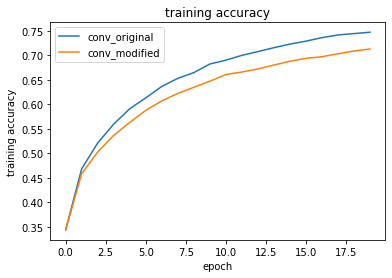

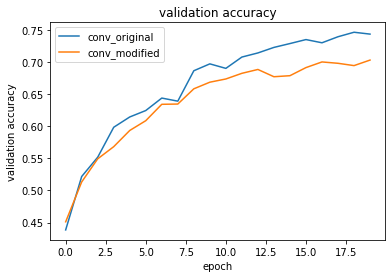

313/313 [==============================] - 1s 3ms/step - loss: 0.8803 - accuracy: 0.7010
Test accuracy original: 0.7407000064849854
Test accuracy mod: 0.7009999752044678


In [4]:
# part 5 -  compare

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import math
import matplotlib.pyplot as plt

# parameters for this script
batch_size = 32
num_classes = 10
epochs = 20          # 20
data_augmentation = False

# Load the data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Define a convolutional neural network
model_original = Sequential()
model_original.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model_original.add(Activation('relu'))
model_original.add(Conv2D(32, (3, 3), padding='same'))
model_original.add(Activation('relu'))
model_original.add(MaxPooling2D(pool_size=(2, 2)))
model_original.add(Dropout(0.25))

model_original.add(Conv2D(64, (3, 3), padding='same'))
model_original.add(Activation('relu'))
model_original.add(Conv2D(64, (3, 3), padding='same'))
model_original.add(Activation('relu'))
model_original.add(MaxPooling2D(pool_size=(2, 2)))
model_original.add(Dropout(0.25))

model_original.add(Flatten())
model_original.add(Dense(512))
model_original.add(Activation('relu'))
model_original.add(Dropout(0.5))
model_original.add(Dense(num_classes))
model_original.add(Activation('softmax'))

# Modified a convolutional neural network with 5*5

model_modified = Sequential()
model_modified.add(Conv2D(32, (5, 5), padding='same',input_shape=x_train.shape[1:]))
model_modified.add(Activation('relu'))
model_modified.add(MaxPooling2D(pool_size=(2, 2)))
model_modified.add(Dropout(0.25))

model_modified.add(Conv2D(64, (5, 5), padding='same'))
model_modified.add(Activation('relu'))
model_modified.add(MaxPooling2D(pool_size=(2, 2)))
model_modified.add(Dropout(0.25))

model_modified.add(Flatten())
model_modified.add(Dense(512))
model_modified.add(Activation('relu'))
model_modified.add(Dropout(0.5))
model_modified.add(Dense(num_classes))
model_modified.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# Compile the conv_model and dense models before using it
model_original.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model_modified.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(model.summary())
print(model_modified.summary())

# normalize the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# partition training set into training and validation set
x_validate = x_train[40000:,:]
x_train = x_train[:40000,:]
y_validate = y_train[40000:,:]
y_train = y_train[:40000,:]

# create a callback that will save the best models while training
save_best_original_model = ModelCheckpoint('best_original_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
save_best_modified_model = ModelCheckpoint('best_modified_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# train without data augmentation
if not data_augmentation:
    print('Not using data augmentation.')
    history_original_model = model_original.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        verbose=1,
                        callbacks=[save_best_original_model])
    
    history_model_modified = model_modified.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        verbose=1,
                        callbacks=[save_best_modified_model])
    
# Plot training accuracy
plt.plot(history_original_model.history['accuracy'])
plt.plot(history_model_modified.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['conv_original', 'conv_modified'], loc='upper left')
plt.show()

# Plot validation accuracy
plt.plot(history_original_model.history['val_accuracy'])
plt.plot(history_model_modified.history['val_accuracy'])
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['conv_original', 'conv_modified'], loc='upper left')
plt.show()

# Evaluate the best conv_model saved (i.e., conv_model with best validation accuracy) on the test set
saved_model = load_model('best_original_model.h5')
saved_modified_model = load_model('best_modified_model.h5')
test_scores_original = saved_model.evaluate(x_test, y_test, verbose=1)
test_scores_modified = saved_modified_model.evaluate(x_test, y_test, verbose=1)
print('Test accuracy original:', test_scores_original[1])
print('Test accuracy mod:', test_scores_modified[1])

The modified convolution neural network has total 2432 parameters in the first layer, and the orginal has 896 parameters in the first layer. It's around 2.71 which makes sense about 25/9. The second layer has 51264/18496 which is 2.77 similar to 25/9 as well. In total 3$\times$ 3 filter has two more layers than 5$\times$ 5 filter one, which should have more parameters than the one with 5$\times$5 filter. From the lectrue, the more parameters, it might cause overfitting. However, the original model has better performance than the modified model. 